In [61]:
import numpy as np
import pandas as pd
import itertools
import random

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

data_path = Path('../abstraction-and-reasoning-challenge/data/')
training_path = data_path / 'training'

training_tasks = sorted(os.listdir(training_path))

In [62]:
# np.array -> [np.array]
def groupByColor_unlifted(pixmap):
    """ Split an image into a collection of images with unique color """
    # Count the number of colors
    nb_colors = int(pixmap.max()) + 1
    # Create a pixmap for each color
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    # Filter out empty images
    return [x for x in splited if np.any(x)]

# np.array -> [np.array]
def cropToContent_unlifted(pixmap):
    """ Crop an image to fit exactly the non 0 pixels """
    # Op argwhere will give us the coordinates of every non-zero point
    true_points = np.argwhere(pixmap)
    if len(true_points) == 0:
        return []
    # Take the smallest points and use them as the top left of our crop
    top_left = true_points.min(axis=0)
    # Take the largest points and use them as the bottom right of our crop
    bottom_right = true_points.max(axis=0)
    # Crop inside the defined rectangle
    pixmap = pixmap[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]
    return [pixmap]

# np.array -> [np.array]
def splitH_unlifted(pixmap):
    """ Split horizontally an image """
    h = pixmap.shape[0]
    if h % 2 == 1:
        h = h // 2
        return [pixmap[:h,:], pixmap[h+1:,:]]
    else:
        h = h // 2
        return [pixmap[:h,:], pixmap[h:,:]]

# np.array -> [np.array]
def negative_unlifted(pixmap):
    """ Compute the negative of an image (and conserve the color) """
    negative = np.logical_not(pixmap).astype(int)
    color = max(pixmap.max(), 1)
    return [negative * color]

In [63]:
# [np.array] -> [np.array]
def identity(x: [np.array]):
    return x

# [np.array] -> [np.array]
def tail(x):
    if len(x) > 1:
        return x[1:]
    else:
        return x

# [np.array] -> [np.array]
def init(x):
    if len(x) > 1:
        return x[:1]
    else:
        return x

# [np.array] -> [np.array]
def union(x):
    """ Compute the pixel union of all images in the list. """
    if len(x) < 2:
        return x
    
    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []
    
    return [np.bitwise_or.reduce(np.array(x).astype(int))]
    
def intersect(x):
    """ Compute the pixel intersection of all images in the list. """
    if len(x) < 2:
        return x
    
    # Make sure everybody have the same shape
    first_shape = tuple(x[0].shape)
    for pixmap in x[1:]:
        if first_shape != tuple(pixmap.shape):
            return []
    
    return [(np.prod(np.array(x), axis=0) > 0).astype(int)]

def sortByColor(xs):
    """ Sort pictures by increasing color id. """
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: x.max()))

def sortByWeight(xs):
    """ Sort images by how many non zero pixels are contained. """
    xs = [x for x in xs if len(x.reshape(-1)) > 0]
    return list(sorted(xs, key=lambda x: (x>0).sum()))

def reverse(x):
    """ Reverse the order of a list of images. """
    return x[::-1]

In [64]:
def lift(fct):
    # Lift the function
    def lifted_function(xs):
        list_of_results = [fct(x) for x in xs]
        return list(itertools.chain(*list_of_results))
    # Give a nice name to the lifted function
    import re
    lifted_function.__name__ = re.sub('_unlifted$', '_lifted', fct.__name__)
    return lifted_function

cropToContent = lift(cropToContent_unlifted)
groupByColor = lift(groupByColor_unlifted)
splitH = lift(splitH_unlifted)
negative = lift(negative_unlifted)

In [65]:
#
# This code is used to display a task
#

cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
def plot_one(ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    input_matrix = task[train_or_test][i][input_or_output]
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(axs[0,i],i,'train','input')
        plot_one(axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(axs[0],0,'test','input')
        plot_one(axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(axs[0,i],i,'test','input')
            plot_one(axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show() 

    
# Display each output of the function
def show_image_list(images):
    """ Show each image contained in a list. """
    p = plt.figure().subplots(1, len(images))
    if len(images) > 1:
        for i, image in enumerate(images):
            p[i].imshow(image, cmap=cmap, norm=norm)
    elif len(images) == 1:
        p.imshow(images[0], cmap=cmap, norm=norm)

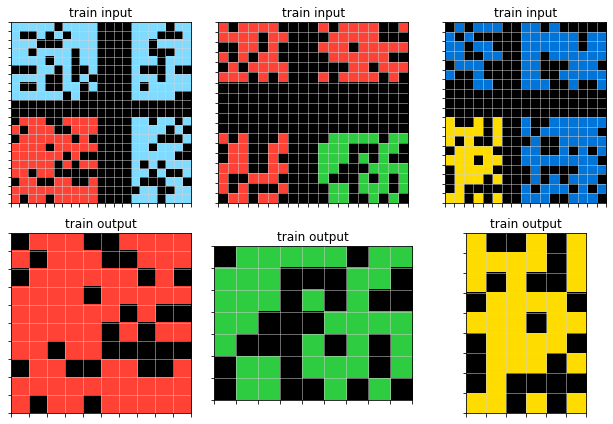

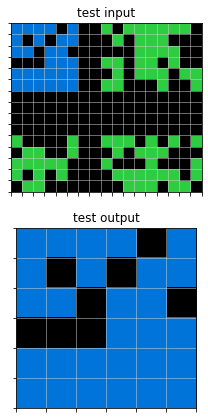

In [66]:
# Load my favorite task
task_file = str(training_path / training_tasks[13])
with open(task_file, 'r') as f:
    task = json.load(f)
    plot_task(task)

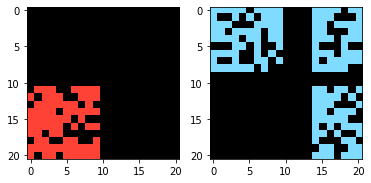

In [67]:
# Execute the group by color on the first input
input_image = np.array(task['train'][0]['input'])
images = groupByColor([input_image])

# Show the result of our function
show_image_list(images)

In [68]:
def program_desc(program):
    """ Create a human readable description of a program. """
    desc = [x.__name__ for x in program]
    return(' >> '.join(desc))

# Display the program description alongside its output
program = [splitH, groupByColor, negative, intersect]
print(program_desc(program))

splitH_lifted >> groupByColor_lifted >> negative_lifted >> intersect


In [69]:
def evaluate(program: [], input_image: np.array):
    # Make sure the input is a np.array
    input_image = np.array(input_image)
    assert type(input_image) == np.ndarray
    
    # Apply each function on the image
    image_list = [input_image]
    for fct in program:
        # Apply the function
        image_list = fct(image_list)
        # Filter out empty images
        image_list = [img for img in image_list if img.shape[0] > 0 and img.shape[1] > 0]
        # Break if there is no data
        if image_list == []:
            return []
    return image_list   

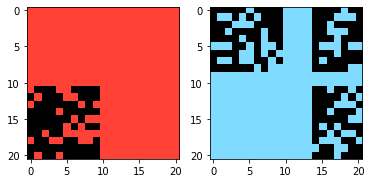

In [70]:
results = evaluate(program=[groupByColor, negative], input_image=task['train'][0]['input'])
show_image_list(results)

In [71]:
def are_two_images_equals(a, b):
    if tuple(a.shape) == tuple(b.shape):
        if (np.abs(b-a) < 1).all():
            return True
    return False

def is_solution(program, task, verbose=True):
    for sample in task: # For each pair input/output
        i = np.array(sample['input'])
        o = np.array(sample['output'])

        # Evaluate the program on the input
        images = evaluate(program, i)
        if len(images) < 1:
            return False
        
        # The solution should be in the 3 first outputs
        images = images[:3]
        
        # Check if the output is in the 3 images produced
        is_program_of_for_sample = any([are_two_images_equals(x, o) for x in images])
        if not is_program_of_for_sample:
            return False
    
    return True

program = [groupByColor, cropToContent]
print(program_desc(program),"is a solution of the task:", is_solution(program, task['train']))

groupByColor_lifted >> cropToContent_lifted is a solution of the task: True


In [72]:
def width_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right width. Less is better."""
    return np.abs(predicted.shape[0] - expected_output.shape[0])

def height_fitness(predicted, expected_output):
    """ How close the predicted image is to have the right height. Less is better."""
    return np.abs(predicted.shape[1] - expected_output.shape[1])

def activated_pixels_fitness(p, e):
    """ How close the predicted image to have the right pixels. Less is better."""
    shape = (max(p.shape[0], e.shape[0]), max(p.shape[1], e.shape[1]))
    diff = np.zeros(shape, dtype=int)
    diff[0:p.shape[0], 0:p.shape[1]] = (p > 0).astype(int)
    diff[0:e.shape[0], 0:e.shape[1]] -= (e > 0).astype(int)
    
    return (diff != 0).sum()

def colors_fitness(p, e):
    p_colors = np.unique(p)
    e_colors = np.unique(e)
    
    nb_inter = len(np.intersect1d(p_colors, e_colors))

    return (len(p_colors) - nb_inter) + (len(e_colors) - nb_inter)

fitness_functions = [colors_fitness, activated_pixels_fitness, height_fitness, width_fitness]

In [73]:
def product_less(a, b):
    """ Return True iff the two tuples a and b respect a<b for the partial order. """
    a = np.array(a)
    b = np.array(b)
    return (np.array(a) < np.array(b)).all()
    

In [74]:
# ([[np.array] -> [np.array]], Taks) -> (int, int, ..., int)
def evaluate_fitness(program, task):
    """ Take a program and a task, and return its fitness score as a tuple. """
    score = np.zeros((len(fitness_functions)))
    
    # For each sample
    for sample in task:
        i = np.array(sample['input'])
        o = np.array(sample['output'])
        
        # For each fitness function
        for index, fitness_function in enumerate(fitness_functions):
            images = evaluate(program, i)
            if images == []: # Penalize no prediction!
                score[index] += 500
            else: # Take only the score of the first output
                score[index] = fitness_function(images[0], o)
    return tuple(score)

print("Fitness evaluation:", evaluate_fitness([groupByColor, cropToContent], task['train']))

Fitness evaluation: (2.0, 130.0, 11.0, 10.0)


In [75]:
def build_candidates(allowed_nodes=[identity], best_candidates=[], nb_candidates=200):
    """
    Create a poll of fresh candidates using the `allowed_nodes`.
    
    The pool contain a mix of new single instructions programs
    and mutations of the best candidates.
    """
    new_candidates = []
    length_limit = 4 # Maximal length of a program
    
    def random_node():
        return random.choice(allowed_nodes)
    
    # Until we have enougth new candidates
    while(len(new_candidates) < nb_candidates):
        # Add 10 new programs
        for i in range(5):
            new_candidates += [[random_node()]]
        
        # Create new programs based on each best candidate
        for best_program in best_candidates:
            # Add one op on its right but limit the length of the program
            if len(best_program) < length_limit - 1:
                new_candidates += [[random_node()] + best_program]
            # Add one op on its left but limit the length of the program
            if len(best_program) < length_limit - 1:
                new_candidates += [best_program + [random_node()]]
            # Mutate one instruction of the existing program
            new_candidates += [list(best_program)]
            new_candidates[-1][random.randrange(0, len(best_program))] = random_node()
   
    # Truncate if we have too many candidates
    np.random.shuffle(new_candidates)
    return new_candidates[:nb_candidates]

# Test the function by building some candidates
len(build_candidates(allowed_nodes=[identity], best_candidates=[[identity]], nb_candidates=42))

42

In [76]:
def build_model(task, max_iterations=20, verbose=True):
    candidates_nodes = [
        tail, init, union, intersect,
        sortByColor, sortByWeight, reverse,
        cropToContent, groupByColor, splitH,
        negative
    ]
    
    if verbose:
        print("Candidates nodes are:", [program_desc([n]) for n in candidates_nodes])
        print()

    best_candidates = {} # A dictionary of {score:candidate}
    for i in range(max_iterations):
        if verbose:
            print("Iteration ", i+1)
            print("-" * 10)
        
        # Create a list of candidates
        candidates = build_candidates(candidates_nodes, best_candidates.values())
        
        # Keep candidates with best fitness.
        # They will be stored in the `best_candidates` dictionary
        # where the key of each program is its fitness score.
        for candidate in candidates:
            score = evaluate_fitness(candidate, task)
            is_uncomparable = True # True if we cannot compare the two candidate's scores
            
            # Compare the new candidate to the existing best candidates
            best_candidates_items = list(best_candidates.items())
            for best_score, best_candidate in best_candidates_items:
                if product_less(score, best_score):
                    # Remove previous best candidate and add the new one
                    del best_candidates[best_score]
                    best_candidates[score] = candidate
                    is_uncomparable = False # The candidates are comparable
                if product_less(best_score, score) or best_score == score:
                    is_uncomparable = False # The candidates are comparable
            if is_uncomparable: # The two candidates are uncomparable
                best_candidates[score] = candidate

        # For each best candidate, we look if we have an answer
        for program in best_candidates.values():
            if is_solution(program, task):
                return program
            
        # Give some informations by selecting a random candidate
        if verbose:
            print("Best candidates lenght:", len(best_candidates))
            random_candidate_score = random.choice(list(best_candidates.keys()))
            print("Random candidate score:", random_candidate_score)
            print("Random candidate implementation:", program_desc(best_candidates[random_candidate_score]))
    return None

In [78]:
program = build_model(task['train'], verbose=True)

print()
if program is None:
    print("No program was found")
else:
    print("Found program:", program_desc(program))

Candidates nodes are: ['tail', 'init', 'union', 'intersect', 'sortByColor', 'sortByWeight', 'reverse', 'cropToContent_lifted', 'groupByColor_lifted', 'splitH_lifted', 'negative_lifted']

Iteration  1
----------
Best candidates lenght: 4
Random candidate score: (2.0, 76.0, 11.0, 0.0)
Random candidate implementation: splitH_lifted
Iteration  2
----------
Best candidates lenght: 12
Random candidate score: (2.0, 76.0, 11.0, 2.0)
Random candidate implementation: splitH_lifted >> cropToContent_lifted
Iteration  3
----------
Best candidates lenght: 25
Random candidate score: (1.0, 43.0, 11.0, 5.0)
Random candidate implementation: splitH_lifted >> reverse >> splitH_lifted
Iteration  4
----------
Best candidates lenght: 36
Random candidate score: (0.0, 99.0, 11.0, 0.0)
Random candidate implementation: negative_lifted >> splitH_lifted >> reverse
Iteration  5
----------
Best candidates lenght: 38
Random candidate score: (2.0, 102.0, 11.0, 0.0)
Random candidate implementation: splitH_lifted >> neg